____
__Universidad de San Andrés__<br/>
__Machine Learning__<br/>
__Modelado probabilístico de audios de ballenas y estudio de transfer learning__<br/>
__Martin Bianchi y Federico Gutman__
____

### Importamos las librerías necesarias

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Audio, display

from models.classification import *
from models.generative import *
from src.preprocessing import *
from src.display import *
from src.metrics import *
from src.utils import *

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold, ParameterGrid, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### NOTAS
- ver repo para preprocesar espectrogrma
    - ver de reducir el y-lim del spectrograma -> averiguar bien entre que frecuencias se mueven los cantos de ballena
- cambiar noise a no right whale
- cambiar el idioma a español
- habria que separar los datos para los modelos generativos en train y val y hacer busqueda de hiperparams
- poner comentarios en cada parte del notebook tipo xq hacemos cada cosa

#### siguientes pasos
- poner ruido en el conjunto de validacion y ver como performan los modelos
- evaluar los modelos en el conjunto de test
- analizar espacios latentes de vae y aae
- usar pca/tsne para ver como se comparan las muestras sintéticas a las reales
- transfer learninig

### Definimos algunas variables globales

In [2]:
SEED = 3            # semilla para reproductibilidad
SR = 2000           # sampling rate
N_FFT = 256         # tamaño de la ventana
HOP_LENGTH = 63     # salto entre frames
N_MELS = 64         # frequency bins (resolución)
MAX_FREQ = 600      # máxima frecuencia para los espectrogramas

### Cargamos los datos y los visualizamos

In [ ]:
train_dir = 'data/whale-detection-challenge/data/train'
test_dir = 'data/whale-detection-challenge/data/test'
labels_dir = 'data/whale-detection-challenge/data/train.csv'

audio_df, labels_df, test_files = load_data(train_dir, test_dir, labels_dir, sampling_rate=SR)

right whale call random audio sample



no whale random audio sample


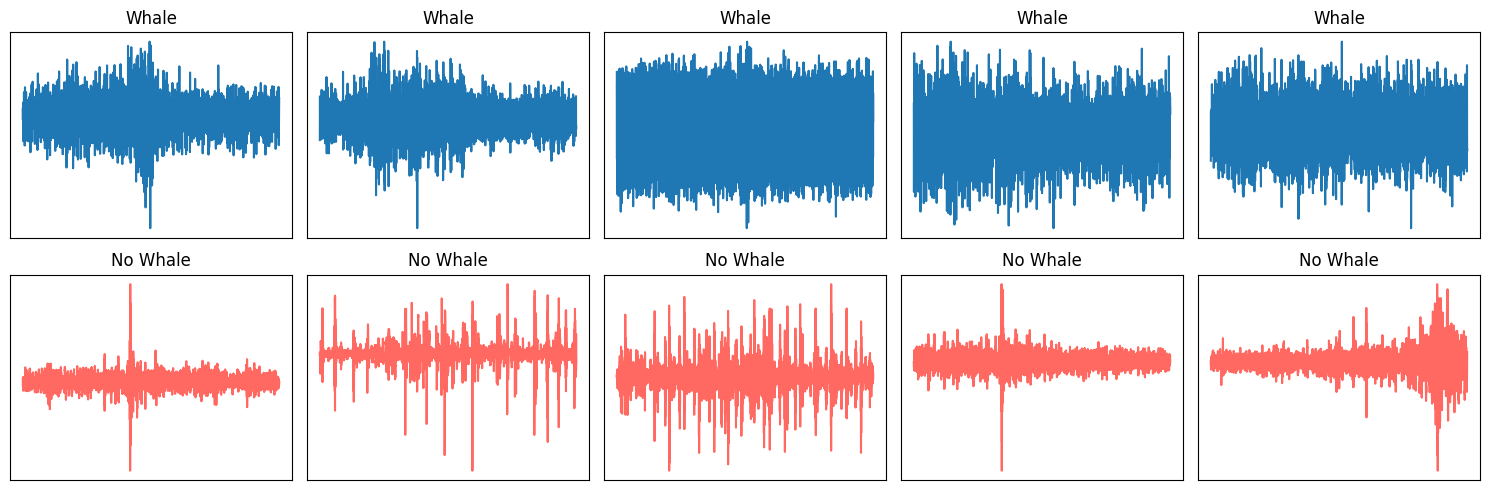

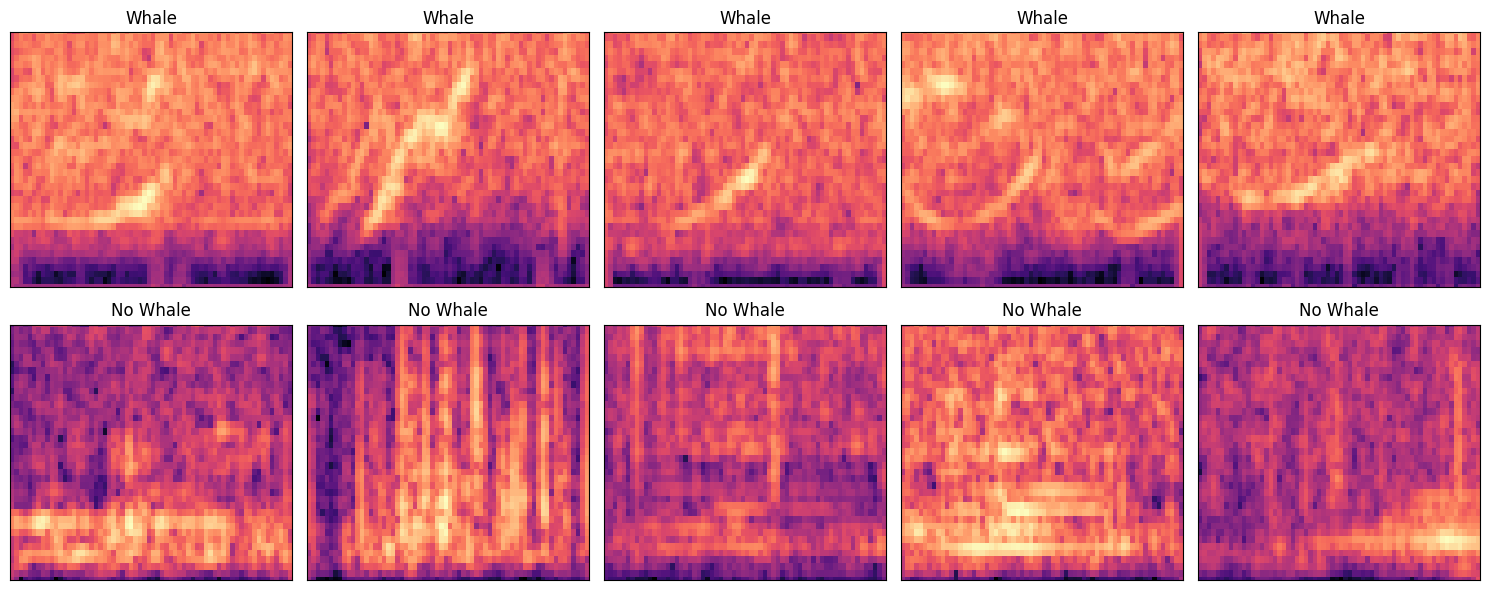

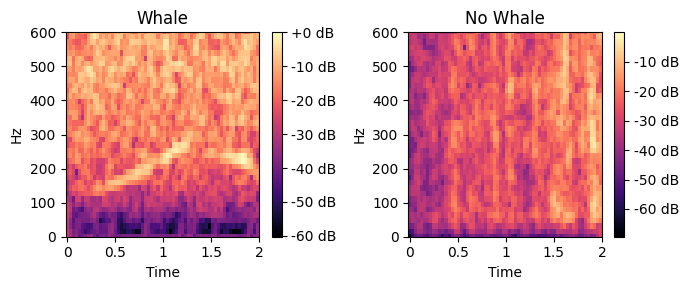

In [ ]:
normalize(audio_df, 'audio')
display_random_samples(audio_df, seed=SEED)

### Hacemos un análisis exploratorio de los datos

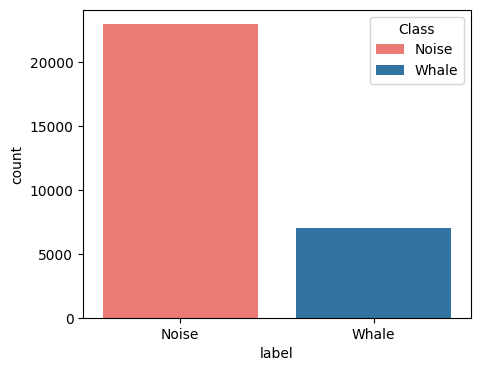

Number of samples: 30000
Number of whale calls: 7027
Number of noise samples: 22973


In [ ]:
show_class_balance(audio_df)

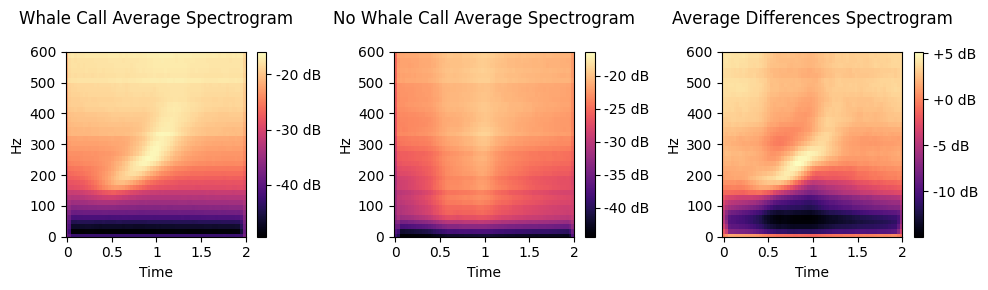

In [7]:
plot_average_spectrograms(audio_df)

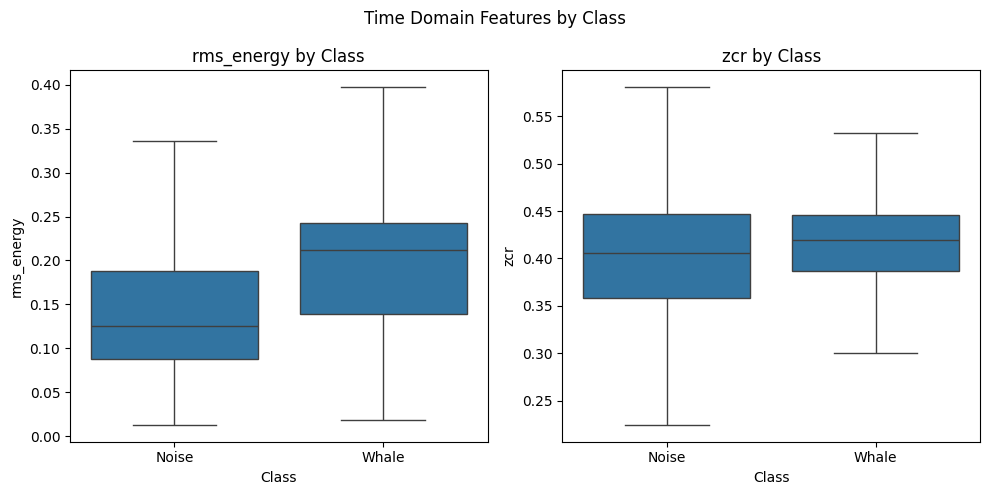

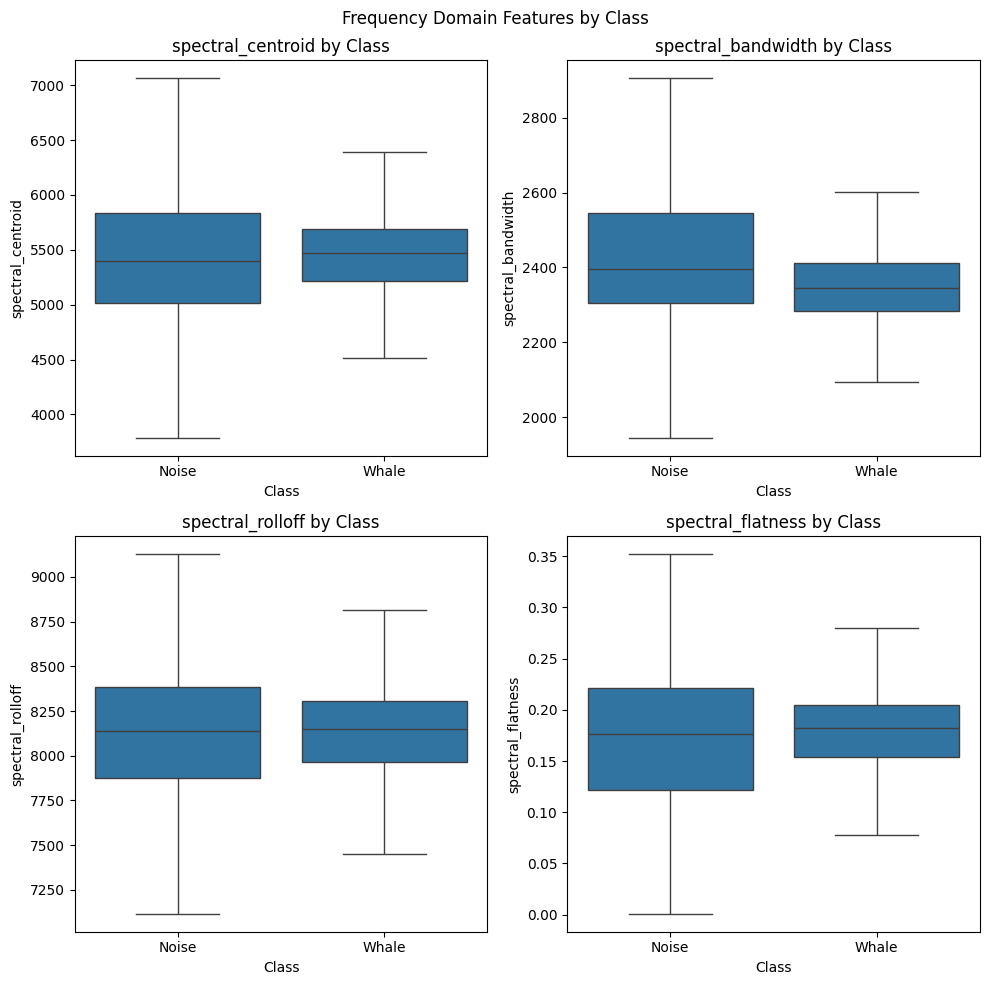

In [8]:
audio_features_df = extract_acoustic_features(audio_df)
display_features_boxplots(audio_features_df)

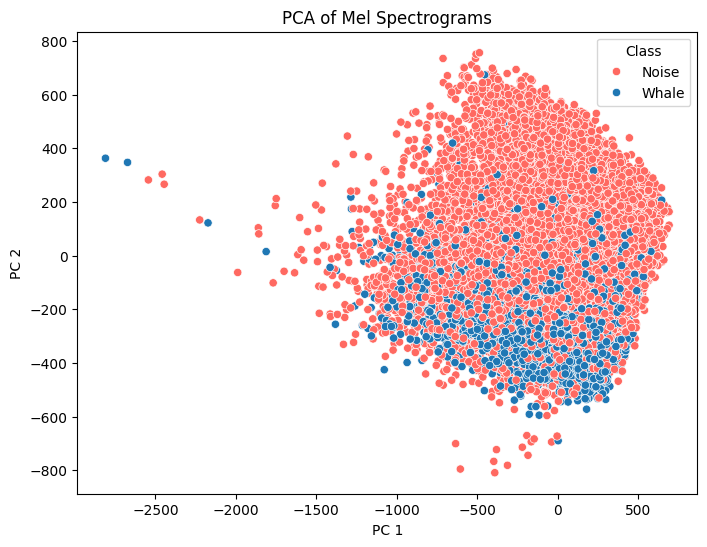

In [ ]:
# EXPERIMENTO PCA
mel_spectrograms = get_all_mel_spectrograms(audio_df)
pca = PCA(n_components=2)
spectrograms_pca = pca.fit_transform(mel_spectrograms)

plot_pca(audio_df, spectrograms_pca)

### Arrancamos el modelado

### Obtenemos los audios de entrenamiento

In [13]:
audio_train_df = audio_df[audio_df['clip_name'].str.contains('train')]

### Hacemos validación cruzada alternando entre una loss con pesos y cambiando la máxima frecuencia de los espectrogramas

explicar lo de las frecuencias de 500 (standard ballena) - y 600 imgs

In [ ]:
X = get_all_mel_spectrograms(audio_train_df)
y = audio_train_df['label'].values

device = torch.device("mps" if torch.mps.is_available() else "cpu")
batch_size = 12

print('Using device:', device)

Using device: cpu


### Preprocesamos los datos para darselos al modelo

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)

### Entrenamos 3 clasificadores

### Entrenamos un MLP

In [ ]:
mlp_torch = MLP(X_train.shape[1]).to(device)

train_losses, val_losses = mlp_torch.train_model(train_loader, val_loader, epochs=20, lr=1e-3)
mlp_torch.plot_learning_curves()

Epoch 1/20 | Train Loss: 0.8545 | Val Loss: 0.3679 | Val Acc: 83.10% | Val AUC: 0.9069
Epoch 2/20 | Train Loss: 0.4011 | Val Loss: 0.3183 | Val Acc: 85.52% | Val AUC: 0.9121
Epoch 3/20 | Train Loss: 0.3701 | Val Loss: 0.4026 | Val Acc: 82.47% | Val AUC: 0.9194
Epoch 4/20 | Train Loss: 0.3553 | Val Loss: 0.4769 | Val Acc: 79.47% | Val AUC: 0.9222
Epoch 5/20 | Train Loss: 0.3376 | Val Loss: 0.5989 | Val Acc: 74.43% | Val AUC: 0.9262
Epoch 6/20 | Train Loss: 0.3223 | Val Loss: 0.4232 | Val Acc: 82.62% | Val AUC: 0.9317
Epoch 7/20 | Train Loss: 0.3229 | Val Loss: 0.3435 | Val Acc: 82.43% | Val AUC: 0.9372
Epoch 8/20 | Train Loss: 0.3214 | Val Loss: 0.3014 | Val Acc: 85.77% | Val AUC: 0.9389
Epoch 9/20 | Train Loss: 0.3150 | Val Loss: 0.3140 | Val Acc: 85.05% | Val AUC: 0.9371
Epoch 10/20 | Train Loss: 0.3073 | Val Loss: 0.3583 | Val Acc: 82.92% | Val AUC: 0.9399
Epoch 11/20 | Train Loss: 0.2952 | Val Loss: 0.3663 | Val Acc: 82.65% | Val AUC: 0.9362
Epoch 12/20 | Train Loss: 0.2924 | Val Lo

### Pasamos los tensores a numpy

In [18]:
X_train_np = X_train_tensor.numpy()
y_train_np = y_train_tensor.numpy()
X_val_np = X_val_tensor.numpy()
y_val_np = y_val_tensor.numpy()

### Entrenamos un Random Forest

In [ ]:
rf_model = train_random_forest(X_train_np, y_train_np, X_val_np, y_val_np)

### Entrenamos un Gradient Boosting

In [ ]:
gb_model = train_gradient_boosting(X_train_np, y_train_np, X_val_np, y_val_np)

### Visualizamos las curvas ROC de los modelos

In [ ]:
mlp_probs = get_mlp_probs(mlp_torch, val_loader, device)
rf_probs = get_model_probs_sklearn(rf_model, X_val_np)
gb_probs = get_model_probs_sklearn(gb_model, X_val_np)

mlp_auc, fpr_mlp, tpr_mlp = compute_roc(y_val_np, mlp_probs)
rf_auc, fpr_rf, tpr_rf = compute_roc(y_val_np, rf_probs)
gb_auc, fpr_gb, tpr_gb = compute_roc(y_val_np, gb_probs)

roc_data = {
    'MLP': (mlp_auc, fpr_mlp, tpr_mlp),
    'Random Forest': (rf_auc, fpr_rf, tpr_rf),
    'Gradient Boosting': (gb_auc, fpr_gb, tpr_gb)
}

plot_roc_curves(roc_data)

### Entrenamos modelos generativos para data augmentation

### Variational Autoencoder (VAE)

### Obtenemos los espectrogramas de todos los cantos de ballena y los estandarizamos

In [ ]:
# MODIFICAR ESTO PARA AGARRAR SOLO LOS DE TRAIN Y ENTRENAR CON ESO

whale_audios = audio_df[audio_df['label'] == 1]

In [25]:
mel_specs = []
for whale_audio in whale_audios['audio']:
    mel = get_melspectrogram(whale_audio) # shape: (64, 64)
    mel = mel[np.newaxis, :, :] # shape: (1, 64, 64)
    mel_specs.append(mel)

### Preparamos los datos para darselos al VAE

In [ ]:
X = np.array(mel_specs)
X, global_mean, global_std = standarize(X)

Global mean: -21.893892288208008, Global std: 11.335094451904297
Shape of X: (7027, 1, 64, 64)


In [ ]:
X_tensor = torch.tensor(X, dtype=torch.float32)
train_loader = DataLoader(TensorDataset(X_tensor), batch_size=batch_size, shuffle=True)

### Entrenamos el VAE y generamos muestras sintéticas

In [ ]:

def train_vae():
    device = torch.device("mps" if torch.mps.is_available() else "cpu")

    epochs = 50
    model = BetaVAE(latent_dim=32).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    beta = 3.0  # Podés empezar en 1.0 e ir probando (0.25, 4.0, etc.)
    for epoch in range(epochs):
        model.train()
        total_loss, total_recon, total_kl = 0, 0, 0
        for batch in train_loader:
            x = batch[0].to(device)

            recon, mu, logvar = model(x)
            loss, recon_loss, kld_loss = model.bvae_loss(recon, x, mu, logvar, beta)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kl += kld_loss.item()

        print(f"Epoch [{epoch+1}], Loss: {total_loss:.2f}, Recon: {total_recon:.2f}, KL: {total_kl:.2f}")
    return model



model = train_vae()
save_model(model)
model = load_model()


[✔] Modelo guardado en: saved_models/bvae.pt
[✔] Modelo cargado desde: saved_models/bvae.pt


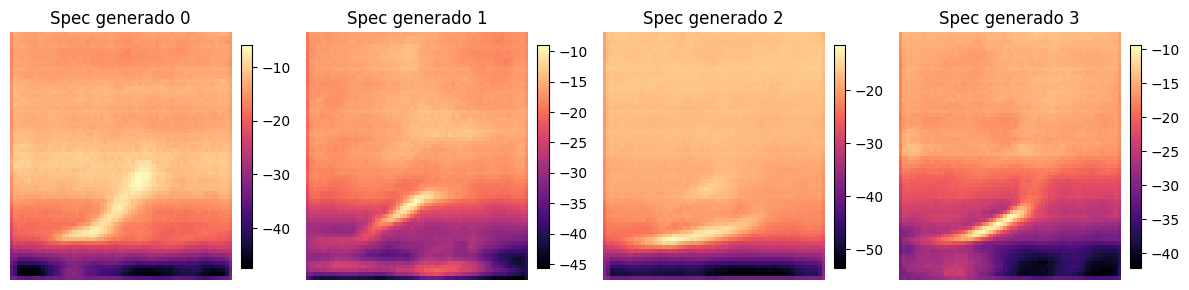

In [56]:
latent_dim = 32

with torch.no_grad():
    # 1. Generá un batch de vectores latentes Z ~ N(0, I)
    z_samples = torch.randn(4, latent_dim).to(device)  # Por ejemplo, 4 muestras
    # 2. Decodificá los Z para obtener espectrogramas
    generated_specs = model.decode(z_samples)

# Ahora `generated_specs` es un tensor de shape [4, 1, 64, 64]

generated_specs = generated_specs.cpu().numpy()

fig, axes = plt.subplots(1, generated_specs.shape[0], figsize=(3 * generated_specs.shape[0], 3))
for i in range(generated_specs.shape[0]):
    spec = generated_specs[i, 0, :, :]
    spec = spec * global_std + global_mean
    ax = axes[i] if generated_specs.shape[0] > 1 else axes
    im = ax.imshow(spec, aspect='auto', origin='lower', cmap='magma')
    ax.set_title(f"Spec generado {i}")
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [57]:
generated_spec = generated_specs[0]  # Tomamos el primer espectrograma generado
spec = generated_spec[0, :, :]  # [64, 64]

# 1️⃣ Desnormalizar
spec = spec * global_std + global_mean

# 2️⃣ Si era Mel, invertir a espectrograma lineal
mel_spec = spec
mel_basis = librosa.filters.mel(sr=SR, n_fft=N_FFT, n_mels=N_MELS)

# Invertir Mel -> STFT
spec_inv = np.linalg.pinv(mel_basis).dot(np.exp(mel_spec))
# Invertir STFT -> Audio
audio = librosa.griffinlim(spec_inv, hop_length=HOP_LENGTH, n_fft=N_FFT)

# Ahora 'audio' es un array de muestras PCM
from IPython.display import Audio
Audio(audio, rate=SR*1.5)

### Visualizamos el espacio latente

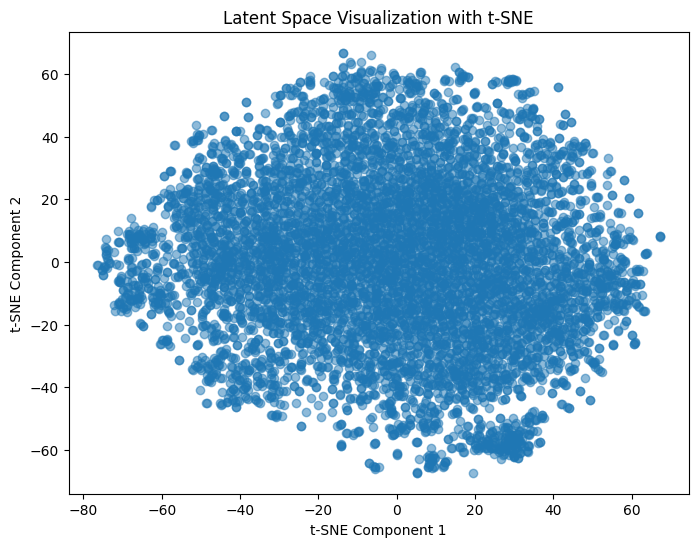

In [31]:
# vemos el latent space con tsne
def plot_latent_space(model, train_loader, device):
    model.eval()
    all_latents = []
    all_labels = []

    with torch.no_grad():
        for batch in train_loader:
            x = batch[0].to(device)
            mu, _ = model.encode(x)
            all_latents.append(mu.cpu().numpy())
            all_labels.extend(batch[1].numpy() if len(batch) > 1 else [0] * mu.size(0))

    all_latents = np.concatenate(all_latents)
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(all_latents)

    plt.figure(figsize=(8, 6))
    plt.scatter(latent_2d[:, 0], latent_2d[:, 1], alpha=0.5)
    plt.title('Latent Space Visualization with t-SNE')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()
plot_latent_space(model, train_loader, device)

### Buscamos hiperparámetros óptimos para el VAE

In [32]:
from sklearn.model_selection import KFold
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset

def objective(trial):
    # Espacios de hiperparámetros
    latent_dim = trial.suggest_int("latent_dim", 2, 128, step=2)
    encoder_layers = trial.suggest_categorical("encoder_layers", [(256,), (512,), (512, 256), (1024, 512, 256)])
    decoder_layers = trial.suggest_categorical("decoder_layers", [(256,), (512,), (256, 512), (256, 512, 1024)])
    activation_fn_name = trial.suggest_categorical("activation_fn", ["ReLU", "LeakyReLU", "ELU", "Sigmoid", "Tanh"])
    activation_map = {
        "ReLU": nn.ReLU,
        "LeakyReLU": nn.LeakyReLU,
        "ELU": nn.ELU,
        "Sigmoid": nn.Sigmoid,
        "Tanh": nn.Tanh
    }
    activation_fn = activation_map[activation_fn_name]

    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    
    # Validación cruzada
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    val_losses = []

    for train_idx, val_idx in kf.split(X):
        # Dividir los datos en entrenamiento y validación
        train_dataset = Subset(TensorDataset(torch.tensor(X, dtype=torch.float32)), train_idx)
        val_dataset = Subset(TensorDataset(torch.tensor(X, dtype=torch.float32)), val_idx)
        
        train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
        
        # Entrenar el modelo
        vae, best_loss = train_vae_model(
            X=X,
            train_loader=train_loader,
            latent_dim=latent_dim,
            encoder_layers=encoder_layers,
            decoder_layers=decoder_layers,
            activation_fn=activation_fn,
            lr=lr,
            weight_decay=weight_decay,
            epochs=50,
            patience=10,
            verbose=False
        )
        
        # Asignar modelo al dispositivo
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        vae.to(device)

        # Evaluación en el conjunto de validación
        vae.eval()
        val_loss = 0
        with torch.no_grad():
            for xb_tuple in val_loader:
                xb = xb_tuple[0].to(device)  # Enviar datos al dispositivo
                x_hat, mu, logvar = vae(xb)
                val_loss += vae.loss(xb, x_hat, mu, logvar).item() * xb.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
    
    # Promediar la pérdida de validación de los pliegues
    return sum(val_losses) / len(val_losses)

# Crear y ejecutar la optimización

# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=50)
# print(f"Best hyperparameters: {study.best_params}")
# print(f"Best validation loss: {study.best_value:.4f}")


In [33]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Función para obtener las representaciones latentes
def obtener_latentes(val_loader, vae, device):
    vae.eval()
    all_mu = []
    all_labels = []
    
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            mu, _ = vae.encode(xb)
            all_mu.append(mu.cpu().numpy())
            all_labels.append(yb.numpy())
    
    all_mu = np.concatenate(all_mu, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    return all_mu, all_labels

# Función para aplicar PCA o t-SNE y visualizar
def visualizar_latente(val_loader, vae, device, metodo='PCA', random_state=None):
    # Obtener las representaciones latentes
    all_mu, all_labels = obtener_latentes(val_loader, vae, device)

    # Aplicar PCA o t-SNE
    if metodo == 'PCA':
        z_latente = PCA(n_components=2).fit_transform(all_mu)
        titulo = "VAE Latent Space (PCA)"
        xlabel, ylabel = "PC 1", "PC 2"
    elif metodo == 't-SNE':
        z_latente = TSNE(n_components=2, random_state=random_state).fit_transform(all_mu)
        titulo = "VAE Latent Space (t-SNE)"
        xlabel, ylabel = "t-SNE 1", "t-SNE 2"
    else:
        raise ValueError("Método debe ser 'PCA' o 't-SNE'.")

    # Graficar
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(z_latente[:, 0], z_latente[:, 1], c=all_labels, cmap='coolwarm', alpha=0.7)
    plt.title(titulo)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar(scatter, label="Clase")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Llamada a la función para PCA
# visualizar_latente(val_loader, vae, device, metodo='PCA')


In [34]:
# Llamada a la función para t-SNE
# visualizar_latente(val_loader, vae, device, metodo='t-SNE', random_state=SEED)

#### Adversarial Autoencoder (AAE)

In [71]:
def train_aae():
    # Entrenamiento
    latent_dim = 32
    encoder = Encoder(latent_dim).to(device)
    decoder = Decoder(latent_dim).to(device)
    discriminator = Discriminator(latent_dim).to(device)

    opt_autoenc = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)
    opt_disc = torch.optim.Adam(discriminator.parameters(), lr=1e-3)

    bce = nn.BCELoss(reduction="sum")
    recon_loss_fn = nn.MSELoss(reduction="sum")

    for epoch in range(50):
        encoder.train(); decoder.train(); discriminator.train()
        total_recon, total_disc, total_gen = 0, 0, 0

        for batch in train_loader:
            x = batch[0].to(device)

            # Reconstruccion
            z = encoder(x)
            x_recon = decoder(z)
            recon_loss = recon_loss_fn(x_recon, x)

            opt_autoenc.zero_grad()
            recon_loss.backward()
            opt_autoenc.step()

            # Discriminador
            z_real = torch.randn_like(z)
            z_fake = encoder(x).detach()
            d_real = discriminator(z_real)
            d_fake = discriminator(z_fake)

            disc_loss = bce(d_real, torch.ones_like(d_real)) + bce(d_fake, torch.zeros_like(d_fake))
            opt_disc.zero_grad()
            disc_loss.backward()
            opt_disc.step()

            # Generador (Encoder)
            z_fake = encoder(x)
            d_fake = discriminator(z_fake)
            gen_loss = bce(d_fake, torch.ones_like(d_fake))

            opt_autoenc.zero_grad()
            gen_loss.backward()
            opt_autoenc.step()

            total_recon += recon_loss.item()
            total_disc += disc_loss.item()
            total_gen += gen_loss.item()

        print(f"Epoch [{epoch}] Recon: {total_recon:.2f}, Disc: {total_disc:.2f}, Gen: {total_gen:.2f}")
    return encoder, decoder, discriminator

def save_aae_models(encoder, decoder, discriminator, path="saved_models/aae"):
    os.makedirs(path, exist_ok=True)
    torch.save(encoder.state_dict(), os.path.join(path, "encoder.pt"))
    torch.save(decoder.state_dict(), os.path.join(path, "decoder.pt"))
    torch.save(discriminator.state_dict(), os.path.join(path, "discriminator.pt"))
    print(f"[✔] AAE guardado en: {path}")

def load_aae_models(latent_dim=32, path="saved_models/aae"):
    device = torch.device("mps" if torch.mps.is_available() else "cpu")

    encoder = Encoder(latent_dim).to(device)
    decoder = Decoder(latent_dim).to(device)
    discriminator = Discriminator(latent_dim).to(device)

    encoder.load_state_dict(torch.load(os.path.join(path, "encoder.pt"), map_location=device))
    decoder.load_state_dict(torch.load(os.path.join(path, "decoder.pt"), map_location=device))
    discriminator.load_state_dict(torch.load(os.path.join(path, "discriminator.pt"), map_location=device))

    encoder.eval()
    decoder.eval()
    discriminator.eval()

    print(f"[✔] AAE cargado desde: {path}")
    return encoder, decoder, discriminator

# encoder, decoder, discriminator = train_aae()
# save_aae_models(encoder, decoder, discriminator)
encoder, decoder, discriminator = load_aae_models(latent_dim=32)

[✔] AAE cargado desde: saved_models/aae


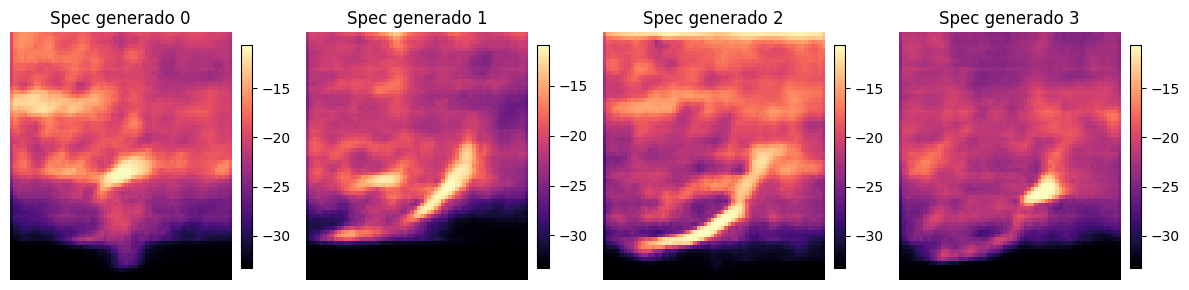

In [72]:
with torch.no_grad():
    z_samples = torch.randn(4, 32).to(device)
    generated_specs = decoder(z_samples)

generated_specs = generated_specs.cpu().numpy()

fig, axes = plt.subplots(1, generated_specs.shape[0], figsize=(3 * generated_specs.shape[0], 3))
for i in range(generated_specs.shape[0]):
    spec = generated_specs[i, 0, :, :]
    spec = spec * global_std + global_mean
    ax = axes[i] if generated_specs.shape[0] > 1 else axes
    im = ax.imshow(spec, aspect='auto', origin='lower', cmap='magma')
    ax.set_title(f"Spec generado {i}")
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [73]:
import librosa
import numpy as np

generated_spec = generated_specs[0]  # Tomamos el primer espectrograma generado
spec = generated_spec[0, :, :]  # [64, 64]

# 1️⃣ Desnormalizar
spec = spec * global_std + global_mean

# 2️⃣ Si era Mel, invertir a espectrograma lineal
mel_spec = spec
mel_basis = librosa.filters.mel(sr=SR, n_fft=N_FFT, n_mels=N_MELS)

# Invertir Mel -> STFT
spec_inv = np.linalg.pinv(mel_basis).dot(np.exp(mel_spec))
# Invertir STFT -> Audio
audio = librosa.griffinlim(spec_inv, hop_length=HOP_LENGTH, n_fft=N_FFT)

# Ahora 'audio' es un array de muestras PCM
from IPython.display import Audio
Audio(audio, rate=SR*1.5)

### Visualizamos el espacio latente

### Entrenamos un Generative Adversarial Network (GAN)
Necesitamo otro prepro

In [105]:
import torch
import torch.nn as nn
import torch.optim as optim
import os

# Dispositivo (Apple MPS GPU si existe, sino CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

def train_gan(train_loader):
    # Crear instancias
    z_dim = 100
    gen = Generator(z_dim).to(device)
    disc = Discriminator().to(device)

    # Criterio de adversarial loss
    criterion = nn.BCEWithLogitsLoss() # probar con sum

    # Optimizadores
    lr = 2e-4
    beta1 = 0.5
    gen_optimizer = optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))
    disc_optimizer = optim.Adam(disc.parameters(), lr=lr, betas=(beta1, 0.999))

    # Carpeta para guardar outputs
    os.makedirs("checkpoints", exist_ok=True)
    os.makedirs("samples", exist_ok=True)

    # Loop de entrenamiento
    epochs = 100  # Cambia si querés
    for epoch in range(1, epochs + 1):
        for batch in train_loader:
            real_images = batch[0].to(device)

            batch_size = real_images.size(0)

            # --------------------------------------------------
            # Entrenar Discriminador
            # --------------------------------------------------
            z = torch.randn(batch_size, z_dim, 1, 1, device=device)
            fake_images = gen(z)

            real_labels = torch.ones(batch_size, device=device)
            fake_labels = torch.zeros(batch_size, device=device)

            disc_optimizer.zero_grad()

            real_preds = disc(real_images)
            loss_real = criterion(real_preds, real_labels)

            fake_preds = disc(fake_images.detach())
            loss_fake = criterion(fake_preds, fake_labels)

            loss_disc = loss_real + loss_fake
            loss_disc.backward()
            disc_optimizer.step()

            # --------------------------------------------------
            # Entrenar Generador
            # --------------------------------------------------
            gen_optimizer.zero_grad()
            fake_preds = disc(fake_images)  # Ahora sin detach
            loss_gen = criterion(fake_preds, real_labels)  # Queremos que diga "reales"
            loss_gen.backward()
            gen_optimizer.step()

        # ---- Fin de la época ----
        print(f"Epoch [{epoch}/{epochs}], "
            f"Loss D: {loss_disc.item():.4f}, "
            f"Loss G: {loss_gen.item():.4f}")

    print("Entrenamiento finalizado ✅")
    return gen, disc

def save_gan_models(gen, disc, path_disc=r"C:\Users\bianc\Machine\TPFINAL\saved_models\gan\disc.pth", path_gen=r"C:\Users\bianc\Machine\TPFINAL\saved_models\gan\gen.pth"):
    os.makedirs(os.path.dirname(path_disc), exist_ok=True)
    os.makedirs(os.path.dirname(path_gen), exist_ok=True)

    torch.save(disc.state_dict(), path_disc)
    torch.save(gen.state_dict(), path_gen)
    print(f"[✔] Discriminador guardado en: {path_disc}")
    print(f"[✔] Generador guardado en: {path_gen}")

def load_gan_models(device, z_dim=100,
                    path_disc=r"saved_models\gan\disc.pth",
                    path_gen=r"saved_models\gan\gen.pth"):

    gen = Generator(z_dim).to(device)
    disc = Discriminator().to(device)

    gen.load_state_dict(torch.load(path_gen, map_location=device))
    disc.load_state_dict(torch.load(path_disc, map_location=device))

    gen.eval()
    disc.eval()

    print(f"[✔] Modelos cargados desde:\n  - {path_gen}\n  - {path_disc}")
    return gen, disc

# gen, disc = train_gan(train_loader)
# save_gan_models(gen, disc)
gen, disc = load_gan_models(device)

Usando dispositivo: cpu
[✔] Modelos cargados desde:
  - saved_models\gan\gen.pth
  - saved_models\gan\disc.pth


In [107]:
import torch
import matplotlib.pyplot as plt

# Asegurate de que 'gen' está en eval mode
gen.eval()

# Generamos un batch de espectrogramas sintéticos
batch_size = 4  # por ejemplo
z_dim = 100
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

with torch.no_grad():
    z = torch.randn(batch_size, z_dim, 1, 1, device=device)
    generated_spec = gen(z).cpu()  # Salida en [-1,1] (usando tanh)

# Ahora generated_spec tiene forma [batch_size, 1, 64, 64]
generated_spec = generated_spec * global_std + global_mean


RuntimeError: The size of tensor a (64) must match the size of tensor b (4096) at non-singleton dimension 3

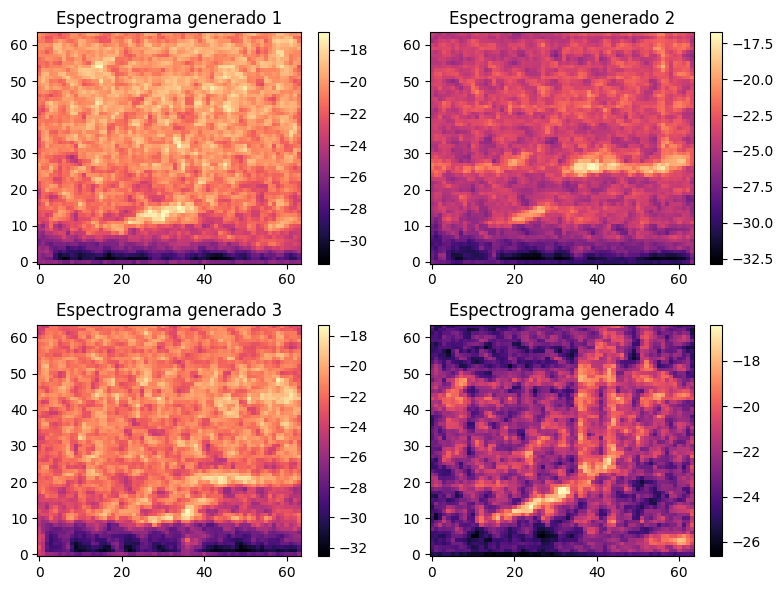

In [77]:
# Plotear los primeros espectrogramas
import matplotlib.pyplot as plt

n_samples = generated_spec.size(0)

plt.figure(figsize=(8, 6))
for i in range(n_samples):
    spec = generated_spec[i, 0].numpy()
    plt.subplot((n_samples + 1) // 2, 2, i + 1)
    plt.imshow(spec, aspect='auto', origin='lower', cmap='magma')
    plt.colorbar()
    plt.title(f"Espectrograma generado {i+1}")

plt.tight_layout()
plt.show()

In [78]:
## escuchamos los espectrogamas

import librosa
def mel_to_audio(mel_spec, sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH):
    # Convertir el espectrograma mel a un espectrograma de magnitud
    mel_spec = librosa.db_to_power(mel_spec)
    audio = librosa.feature.inverse.mel_to_audio(mel_spec, sr=sr, n_fft=n_fft, hop_length=hop_length)
    return audio
# Convertir los espectrogramas generados a audio
generated_audios = []
for spec in generated_spec:
    audio = mel_to_audio(spec.numpy(), sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH)
    generated_audios.append(audio)
# Escuchar los primeros 4 audios generados
for i, audio in enumerate(generated_audios[:4]):
    print(f"Escuchando audio generado {i+1}:")
    display(Audio(audio, rate=SR*1.5))


Escuchando audio generado 1:


Escuchando audio generado 2:


Escuchando audio generado 3:


Escuchando audio generado 4:


In [118]:
X = get_all_mel_spectrograms(audio_train_df)
y = audio_train_df['label'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

# Ejemplo de estandarización previa
global_mean = X_train.mean(axis=0)
global_std = X_train.std(axis=0) + 1e-8  # Para evitar división por 0

X_train_std = (X_train - global_mean) / global_std
X_val_std = (X_val - global_mean) / global_std

# Luego usás X_train_std para los tensores
X_train_tensor = torch.tensor(X_train_std, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_std, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

batch_size = 128
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)

In [115]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score
import copy 

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_layers=[256, 128, 64], output_dim=2):
        super(MLP, self).__init__()
        layers = []
        prev_dim = input_dim

        for hidden_layer in hidden_layers:
            layers.append(nn.Linear(prev_dim, hidden_layer))
            layers.append(nn.ReLU())
            prev_dim = hidden_layer
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)
        self.device = torch.device('mps' if torch.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')

    def forward(self, x):
        return self.model(x)

    def train_model(self, train_loader, val_loader, epochs=50, lr=0.001, weight_decay=1e-5,
                    early_stopping_patience=None, use_class_weights=True):
        self.to(self.device)

        # Loss function
        if use_class_weights:
            y_train = train_loader.dataset.tensors[1].cpu().numpy().flatten()
            weights = get_class_weights(y_train).to(self.device)
            loss_function = nn.CrossEntropyLoss(weight=weights)
        else:
            loss_function = nn.CrossEntropyLoss()

        optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        train_losses = []
        val_losses = []

        best_val_f1 = 0.0
        best_model_state = None
        patience_counter = 0

        for epoch in range(epochs):
            self.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)

            avg_train_loss = running_loss / len(train_loader.dataset)
            train_losses.append(avg_train_loss)

            val_loss, val_acc, val_f1, val_auc = self.evaluate(val_loader, return_metrics=True)
            val_losses.append(val_loss)

            print(f'Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | '
                f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val F1: {val_f1:.4f} | Val AUC: {val_auc:.4f}')

            # Early stopping con F1
            if early_stopping_patience is not None:
                if val_f1 > best_val_f1:
                    best_val_f1 = val_f1
                    best_model_state = copy.deepcopy(self.state_dict())
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= early_stopping_patience:
                        print("Early stopping triggered (F1 no mejoró).")
                        break

        # Restaurar el mejor modelo
        if best_model_state is not None:
            self.load_state_dict(best_model_state)

        return train_losses, val_losses


    from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

    def evaluate(self, val_loader, return_metrics=False):
        self.eval()
        val_loss = 0.0
        all_labels = []
        all_probs = []
        all_preds = []

        loss_function = nn.CrossEntropyLoss()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self(inputs)
                loss = loss_function(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                probs = torch.softmax(outputs, dim=1)[:, 1]
                preds = torch.argmax(outputs, dim=1)

                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader.dataset)
        acc = accuracy_score(all_labels, all_preds)
        try:
            auc = roc_auc_score(all_labels, all_probs)
        except ValueError:
            auc = 0.0  # puede fallar si hay una sola clase
        f1 = f1_score(all_labels, all_preds)

        if return_metrics:
            return avg_val_loss, acc * 100, f1, auc

        print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {acc * 100:.2f}%, F1: {f1:.4f}, AUC: {auc:.4f}')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score
from torch.utils.data import DataLoader, TensorDataset
import copy

# ==== Generación de datos sintéticos ====

def generate_synthetic_samples(method, n_samples, device, gen=None):
    batch_size = 128
    specs = []

    if method == "vae":
        while len(specs) < n_samples:
            z = torch.randn(min(batch_size, n_samples - len(specs)), 32).to(device)
            with torch.no_grad():
                gen_batch = model.decode(z).cpu().numpy()
            specs.extend(gen_batch)

    elif method == "aae":
        while len(specs) < n_samples:
            z = torch.randn(min(batch_size, n_samples - len(specs)), 32).to(device)
            with torch.no_grad():
                gen_batch = decoder(z).cpu().numpy()
            specs.extend(gen_batch)

    elif method == "gan":
        assert gen is not None, "Debe pasar el generador `gen` para GAN"
        z_dim = 100
        while len(specs) < n_samples:
            z = torch.randn(min(batch_size, n_samples - len(specs)), z_dim, 1, 1).to(device)
            with torch.no_grad():
                gen_batch = gen(z).cpu().numpy()  # ✅ sin flatten
            specs.extend(gen_batch)

    else:
        raise ValueError(f"Método '{method}' no reconocido")

    return np.array(specs[:n_samples])

# ==== Loader con sintéticos ====

def build_loader_with_synthetic(X_train, y_train, synth_data, batch_size=128):
    synth_X = torch.tensor(synth_data, dtype=torch.float32)
    if synth_X.dim() > 2:
        synth_X = synth_X.view(synth_X.size(0), -1)
    synth_y = torch.ones(len(synth_data), dtype=torch.long)

    X_comb = torch.cat([X_train, synth_X], dim=0)
    y_comb = torch.cat([y_train, synth_y], dim=0)

    dataset = TensorDataset(X_comb, y_comb)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

# ==== Experimentos ====

def run_experiment(method, n_samples=0, use_class_weights=False, tag=None):
    print(f"\n[🏁] Método: {method}, Synth: {n_samples}, Weights: {use_class_weights}")

    if n_samples > 0:
        synth = generate_synthetic_samples(method, n_samples, device, gen=gen)
        new_loader = build_loader_with_synthetic(X_train_tensor, y_train_tensor, synth)
    else:
        new_loader = train_loader

    mlp = MLP(X_train.shape[1]).to(device)
    mlp.train_model(new_loader, val_loader,
                    epochs=40,
                    lr=1e-3,
                    early_stopping_patience=7,
                    use_class_weights=use_class_weights)

    val_loss, acc, f1, auc = mlp.evaluate(val_loader, return_metrics=True)
    print(f"[✅] ACC: {acc:.2f}% | F1: {f1:.4f} | AUC: {auc:.4f}")

    return {
        "Método": tag or method,
        "LOSS": val_loss,
        "ACC": acc,
        "F1": f1,
        "AUC": auc
    }

# ==== Entrenamiento final ====

results = []

results.append(run_experiment(method="normal", n_samples=0, use_class_weights=False, tag="MLP Normal"))
results.append(run_experiment(method="normal", n_samples=0, use_class_weights=True, tag="MLP + Pesos"))

results.append(run_experiment(method="vae", n_samples=15946, use_class_weights=False, tag="VAE Full"))
results.append(run_experiment(method="aae", n_samples=15946, use_class_weights=False, tag="AAE Full"))
results.append(run_experiment(method="gan", n_samples=15946, use_class_weights=False, tag="GAN Full"))

results.append(run_experiment(method="vae", n_samples=5000, use_class_weights=False, tag="VAE Poco"))
results.append(run_experiment(method="aae", n_samples=5000, use_class_weights=False, tag="AAE Poco"))
results.append(run_experiment(method="gan", n_samples=5000, use_class_weights=False, tag="GAN Poco"))

# ==== Combinados ====

comb_data = np.concatenate([
    generate_synthetic_samples("vae", 5315, device),
    generate_synthetic_samples("aae", 5315, device),
    generate_synthetic_samples("gan", 5316, device, gen=gen),
])
loader_mix_full = build_loader_with_synthetic(X_train_tensor, y_train_tensor, comb_data)
mlp = MLP(X_train.shape[1]).to(device)
mlp.train_model(loader_mix_full, val_loader,
                epochs=40,
                lr=1e-3,
                early_stopping_patience=7,
                use_class_weights=False)
val_loss, acc, f1, auc = mlp.evaluate(val_loader, return_metrics=True)
results.append({
    "Método": "Combinado Full",
    "LOSS": val_loss,
    "ACC": acc,
    "F1": f1,
    "AUC": auc
})

comb_data = np.concatenate([
    generate_synthetic_samples("vae", 666, device),
    generate_synthetic_samples("aae", 667, device),
    generate_synthetic_samples("gan", 667, device, gen=gen),
])
loader_mix_poco = build_loader_with_synthetic(X_train_tensor, y_train_tensor, comb_data)
mlp = MLP(X_train.shape[1]).to(device)
mlp.train_model(loader_mix_poco, val_loader,
                epochs=40,
                lr=1e-3,
                early_stopping_patience=7,
                use_class_weights=False)
val_loss, acc, f1, auc = mlp.evaluate(val_loader, return_metrics=True)
results.append({
    "Método": "Combinado Poco",
    "LOSS": val_loss,
    "ACC": acc,
    "F1": f1,
    "AUC": auc
})

# ==== Mostrar tabla ====

df = pd.DataFrame(results)
print(df.to_string(index=False))



[🏁] Método: normal, Synth: 0, Weights: False
Epoch 1/40 | Train Loss: 0.2838 | Val Loss: 0.2681 | Val Acc: 87.50% | Val F1: 0.7199 | Val AUC: 0.9369
Epoch 2/40 | Train Loss: 0.2324 | Val Loss: 0.2432 | Val Acc: 88.68% | Val F1: 0.7544 | Val AUC: 0.9478
Epoch 3/40 | Train Loss: 0.2116 | Val Loss: 0.2526 | Val Acc: 88.75% | Val F1: 0.7585 | Val AUC: 0.9458
Epoch 4/40 | Train Loss: 0.1943 | Val Loss: 0.2433 | Val Acc: 89.28% | Val F1: 0.7722 | Val AUC: 0.9497
Epoch 5/40 | Train Loss: 0.1694 | Val Loss: 0.2684 | Val Acc: 88.67% | Val F1: 0.7531 | Val AUC: 0.9444
Epoch 6/40 | Train Loss: 0.1449 | Val Loss: 0.2701 | Val Acc: 89.42% | Val F1: 0.7749 | Val AUC: 0.9523
Epoch 7/40 | Train Loss: 0.1216 | Val Loss: 0.3104 | Val Acc: 89.88% | Val F1: 0.7805 | Val AUC: 0.9526
Epoch 8/40 | Train Loss: 0.1053 | Val Loss: 0.3125 | Val Acc: 89.38% | Val F1: 0.7693 | Val AUC: 0.9490
Epoch 9/40 | Train Loss: 0.0905 | Val Loss: 0.4170 | Val Acc: 88.62% | Val F1: 0.7589 | Val AUC: 0.9422
Epoch 10/40 | Trai

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 4 dimension(s) and the array at index 2 has 2 dimension(s)

In [ ]:
df_results = pd.DataFrame(results)
print("\n📊 Resultados:")
print(df_results.sort_values(by="AUC", ascending=False).to_string(index=False))